In [5]:
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
import random
import json

In [2]:
# Define paths to the images and YOLO labels
image_dir = Path("../projects/test_cutouts/TEST_small/results/images")
label_dir = Path("../projects/test_cutouts/TEST_small/results/yolo_bbox_labels")

In [12]:
def load_class_id_to_common_name(json_path):
    """
    Load the species JSON file that maps class_ids to common names.
    """
    with open(json_path, "r") as json_file:
        species_data = json.load(json_file)

    # Create a lookup dictionary from the JSON, mapping class_id to common_name
    class_id_to_common_name = {info["class_id"]: info["common_name"] for info in species_data["species"].values()}
    return class_id_to_common_name

# Function to load YOLO bounding boxes from a label file
def load_yolo_bboxes(label_path, img_width, img_height):
    """
    Load YOLO bounding boxes from a label file.

    Args:
        label_path (Path): Path to the label file.
        img_width (int): Width of the image.
        img_height (int): Height of the image.

    Returns:
        List of bounding boxes in the format [class_id, x_min, y_min, x_max, y_max].
    """
    bboxes = []
    with open(label_path, 'r') as file:
        lines = file.readlines()
        for line in lines:
            parts = line.strip().split()
            class_id = int(parts[0])
            center_x, center_y, bbox_width, bbox_height = map(float, parts[1:])
            
            # Convert YOLO format (center_x, center_y, width, height) to (x_min, y_min, x_max, y_max)
            x_min = int((center_x - bbox_width / 2) * img_width)
            y_min = int((center_y - bbox_height / 2) * img_height)
            x_max = int((center_x + bbox_width / 2) * img_width)
            y_max = int((center_y + bbox_height / 2) * img_height)
            
            bboxes.append([class_id, x_min, y_min, x_max, y_max])
    
    return bboxes

# Function to visualize a limited number of bounding boxes on an image
def visualize_bboxes(image, bboxes, class_id_to_name, num_boxes_to_display=5):
    """
    Visualize a limited number of bounding boxes on an image, mapping class_id to common_name.

    Args:
        image (np.ndarray): The image on which to draw the bounding boxes.
        bboxes (List[List[int]]): List of bounding boxes in the format [class_id, x_min, y_min, x_max, y_max].
        class_id_to_name (dict): Mapping of class_id to common_name from the JSON.
        num_boxes_to_display (int): Number of bounding boxes to display (default is 5).
    """
    img_with_boxes = image.copy()
    img_height, img_width = img_with_boxes.shape[:2]

    # Dynamically calculate the font scale based on image size
    base_scale = 0.8
    font_scale = max(img_width, img_height) / 1000 * base_scale
    font_thickness = int(font_scale * 2)
    
    # If there are more boxes than the limit, randomly select a subset
    if len(bboxes) > num_boxes_to_display:
        bboxes = random.sample(bboxes, num_boxes_to_display)

    for bbox in bboxes:
        class_id, x_min, y_min, x_max, y_max = bbox
        common_name = class_id_to_name.get(class_id, "Unknown")  # Get common name
        
        # Draw the bounding box on the image
        cv2.rectangle(img_with_boxes, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)
        # Dynamically set the text size based on image dimensions
        cv2.putText(img_with_boxes, common_name, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, font_scale, (255, 0, 0), font_thickness)
    
    return img_with_boxes

# Function to load and visualize a single image with bounding boxes
def validate_and_visualize(image_path, label_path, class_id_to_name, num_boxes_to_display=5):
    """
    Load an image and its corresponding bounding boxes, visualize the results.

    Args:
        image_path (Path): Path to the image file.
        label_path (Path): Path to the YOLO label file.
        class_id_to_name (dict): Mapping of class_id to common_name from the JSON.
    """
    # Load the image
    image = cv2.imread(str(image_path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_height, img_width = image.shape[:2]
    
    # Load the bounding boxes
    bboxes = load_yolo_bboxes(label_path, img_width, img_height)
    
    # Visualize the bounding boxes on the image with common names
    img_with_bboxes = visualize_bboxes(image, bboxes, class_id_to_name, num_boxes_to_display=num_boxes_to_display)
    
    # Plot the original and annotated image
    plt.figure(figsize=(10, 10))
    plt.imshow(img_with_bboxes)
    plt.axis("off")
    plt.show()

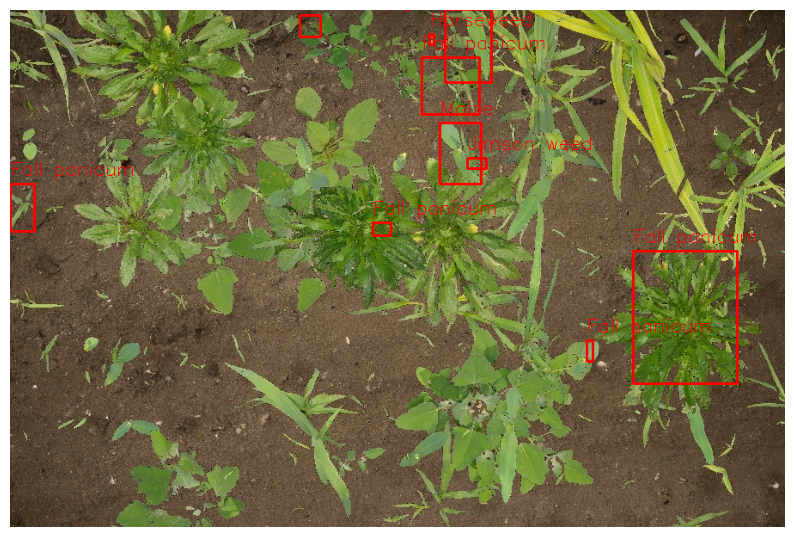

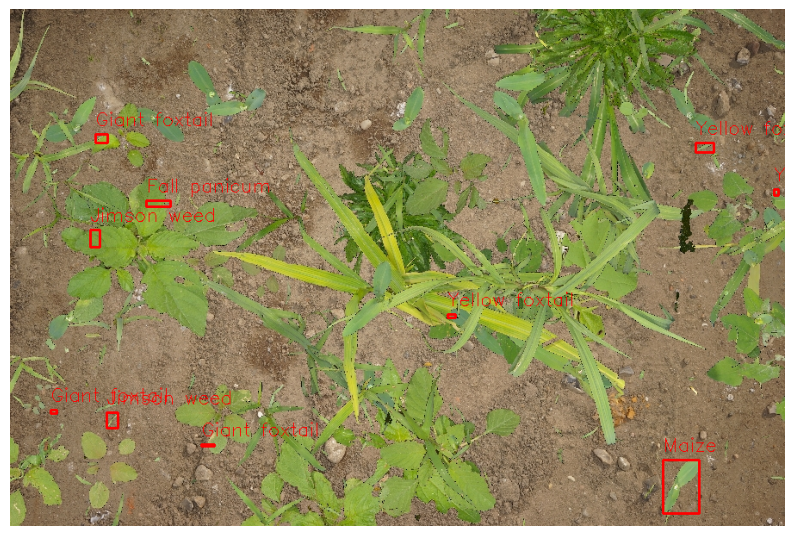

In [15]:

# Validate and visualize bounding boxes for each image
image_files = list(image_dir.glob("*.jpg"))
# random.seed(42)
image_files = random.sample(image_files, 2)
class_id_to_common_name = load_class_id_to_common_name("../data/species_info.json")

for image_path in image_files:
    label_path = label_dir / (image_path.stem + ".txt")
    if label_path.exists():
        validate_and_visualize(image_path, label_path, class_id_to_common_name, num_boxes_to_display=10)
    else:
        print(f"Label file not found for {image_path.stem}")